In [5]:
import mne
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy.io import loadmat
from scipy import signal
import os
from mne.connectivity import spectral_connectivity, phase_slope_index

In [6]:
data =pd.read_csv('/Users/zubrikhina/Documents/datasets/EEG_baseline_with_markers/EEG_baseline_Kz_2020_cv/path_file.csv')

In [7]:
DATA_PATH ='/Users/zubrikhina/Documents/datasets/EEG_baseline_with_markers/EEG_baseline_Kz_2020_cv/'

In [8]:
RESULT_PATH='/Users/zubrikhina/Documents/datasets/EEG_baseline_with_markers/cross_spectrum_short'

## Посмотрим на распределение по времени

In [9]:
data['fn'] = Path(DATA_PATH) / data['fn']

In [10]:
data_norm =data.loc[data['target']==False].sample(frac=1)[:50]
data_mdd =data.loc[data['target']==True]

In [11]:
data =pd.concat([data_norm,data_mdd])

In [12]:
data =data.reset_index(drop=True)

In [13]:
sizes =[]

In [14]:
sample =pd.read_csv(data['fn'][0])

In [11]:
sample

,Unnamed: 0,time,Fp1,Fp2,F3,F4,Fz,C3,C4,Cz,P3,P4,Pz,O1,O2,F7,F8
0,0,0,0.108254,0.112312,0.075195,0.050483,0.027044,0.002601,0.015361,0.039640,-0.019764,-0.036932,-0.036764,-0.015082,-0.052676,0.051894,0.022405
1,1,2,0.755046,0.470095,0.112089,-0.209015,0.582968,0.483172,-0.012106,-0.100822,0.445049,0.598486,0.374713,0.059873,0.560477,0.901561,0.825743
2,2,4,1.454738,0.831393,0.153317,-0.504398,1.155721,1.013013,-0.055095,-0.238608,0.959375,1.272818,0.800337,0.156396,1.210200,1.828710,1.674676
3,3,6,2.244169,1.194480,0.202423,-0.863496,1.752351,1.627154,-0.127274,-0.370102,1.558362,2.009827,1.245690,0.290773,1.918439,2.887924,2.596686
4,4,8,3.131640,1.548982,0.261464,-1.299354,2.363309,2.335201,-0.238536,-0.490329,2.251510,2.806906,1.701856,0.469672,2.681765,4.093011,3.587806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64495,64495,128990,-1.009704,-2.752282,-2.475238,-4.129721,-3.897328,-3.240002,-3.962945,-4.236389,-2.478830,-2.530800,-2.656756,-2.340031,-1.394740,-1.731157,-2.842280
64496,64496,128992,-1.132413,-1.900583,-2.009335,-2.815600,-2.590164,-2.439533,-2.761641,-3.380407,-1.751889,-1.636083,-1.610353,-1.133865,-0.624205,-1.615592,-2.046284
64497,64497,128994,-0.955324,-1.160294,-1.405585,-1.671636,-1.505206,-1.592234,-1.658170,-2.327217,-1.072524,-0.876425,-0.802352,-0.384572,-0.143296,-1.248381,-1.287804
64498,64498,128996,-0.545208,-0.526035,-0.705793,-0.686014,-0.619581,-0.723058,-0.652055,-1.131703,-0.442135,-0.241152,-0.199961,-0.006424,0.096343,-0.689277,-0.575240


In [12]:
del sample['Unnamed: 0']
electrodes =sample.columns[1:].to_list()

In [14]:
for i in range(data.shape[0]):
    sample =pd.read_csv(data['fn'][i])
    sizes.append(sample.shape[0])

(array([ 8., 50., 12.,  5., 85.,  1.,  1.,  0.,  0.,  1.]),
 array([ 21500.,  31000.,  40500.,  50000.,  59500.,  69000.,  78500.,
         88000.,  97500., 107000., 116500.]),
 <BarContainer object of 10 artists>)

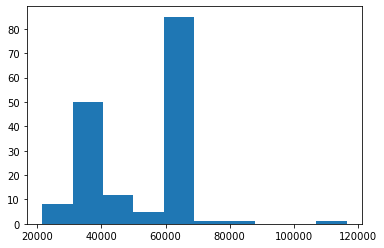

In [15]:
plt.hist(sizes, bins=10)

In [16]:
360000/21500

16.74418604651163

In [17]:
16

16

In [18]:
band_bounds = {
    'theta' : [4, 8],
    'alpha': [8, 13],
    'beta': [13, 30],
    'gamma': [30, 45]}

In [19]:
def extract_spectogram(sample, channel_name):
    print('Channel name:', channel_name)
    sr =500
    eeg =  sample[channel_name].values
    time = sample['time'].values

    print('Sampling rate = %d samples/sec'%sr)
    print(time.shape[0]/500)
    # now we will analyze window lenghts of 500 ms in 125 ms steps. 
    # Signals will overlap 475 ms
    WinLength = int(0.5*sr) # 500 points (0.5 sec, 500 ms)
    step = int(0.25*sr) # 25 points (or 25 ms)
    myparams = dict(nperseg = WinLength, noverlap =None, return_onesided=True, mode='magnitude')
    f, nseg, Sxx = signal.spectrogram(x = eeg, fs = sr, **myparams)
    X = nseg
    Y = f
    Z = Sxx
    levels = 45
    #spectrum = plt.contourf(X,Y[:24],Z[:24],levels, cmap='jet')#,'linecolor','none')
    #plt.show()
    print(Z[:24].shape)
    return Z[:24]

In [24]:
def get_mne_spec_con_feats(df,electrodes, sfreq=125., band=None, method='coh'):

    res = spectral_connectivity(
        df[electrodes].values.T.reshape(1, len(electrodes), -1),
        method=method, sfreq=sfreq, verbose=False)

    data = res[0]
    freqs = res[1]

    def filter(arr):
        if band is None:
            return arr
        else:
            start_idx = np.where(freqs > band_bounds[band][0])[0][0]
            end_idx = np.where(freqs < band_bounds[band][1])[0][-1] + 1
            return arr[start_idx:end_idx]

    d=filter(data).mean(axis=2)
    print(d.shape)
    return d

In [50]:
dictns ={1: 'MDD', 0: 'Health'}

In [51]:
data['fn'] = Path(DATA_PATH) / data['fn']

In [52]:
80000/500

160.0

In [53]:
mean_sample =0

In [54]:
def formulate_samples(sample, batch_size =21500):
    n_splits =sample.shape[0] // batch_size
    samples =[]
    for split_i in range(n_splits):
        samples.append(sample[batch_size*split_i: batch_size*(split_i+1)])
    return  samples   

In [57]:
def generate_spectograms(data, spectrum_type='simple'):
    for i in range(data.shape[0]):
        df =pd.read_csv(data['fn'][i])
        samples =formulate_samples(df)

        for j, sample in enumerate(samples):
            target =data['target'][i]
            new_path =Path(RESULT_PATH)/ dictns[target] / (data['fn'][i].stem + "_"+str(j)+'.npy')
            if not os.path.exists(new_path):    
                del sample['Unnamed: 0']
                electrodes =sample.columns[1:].to_list()
                spectrums =[]
                
                if spectrum_type=='simple':
                    for electrode in electrodes:
                        spectrum =extract_spectogram(sample, electrode)
                        spectrums.append(spectrum)
                else:
                    for band in band_bounds.keys():
                        spectrum=get_mne_spec_con_feats(df,electrodes, sfreq=500, band=None, method='coh')
                        spectrums.append(spectrum)
                        
                full_spectrum =np.stack(spectrums)
                with open(new_path, 'wb') as f:
                    np.save(f, full_spectrum)

                print('------------------------------------------')

In [58]:
generate_spectograms(data, spectrum_type='cross')

(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
----------------

(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
----------------

(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
------------------------------------------
(15, 15)
(15, 15)
(15, 15)
(15, 15)
----------------

In [120]:
all_data =[]
for i in range(data.shape[0]):
    df =pd.read_csv(data['fn'][i])
    del df['Unnamed: 0']
    electrodes =df.columns[1:].to_list()
    all_data.append(df[electrodes].values[:21500])

In [121]:
all_data[0].shape

(21500, 15)

In [122]:
all_data[1].shape

(21500, 15)

In [123]:
all_exp_array =np.stack(all_data)

In [126]:
all_exp_array=all_exp_array.reshape(163,15,-1)

In [21]:
del df['Unnamed: 0']
electrodes =df.columns[1:].to_list()

In [22]:
electrodes

['Fp1',
 'Fp2',
 'F3',
 'F4',
 'Fz',
 'C3',
 'C4',
 'Cz',
 'P3',
 'P4',
 'Pz',
 'O1',
 'O2',
 'F7',
 'F8']

In [25]:
spect_1 =get_mne_spec_con_feats(df,electrodes, sfreq=500, band=None, method='coh')

(15, 15)


In [27]:
spect_1

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.94726347, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.91789357, 0.92408821, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.6967627 , 0.77555568, 0.82346157, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.87545319, 0.88373278, 0.83830587, 0.72973597, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 

In [30]:
df[electrodes].values.T.reshape(1, len(electrodes), -1).shape

(1, 15, 43500)

In [28]:
 res = spectral_connectivity(
        df[electrodes].values.T.reshape(1, len(electrodes), -1),
        method='coh', sfreq=500, verbose=False)

In [33]:
res[0].mean(axis=2)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.94726347, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.91789357, 0.92408821, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.6967627 , 0.77555568, 0.82346157, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.87545319, 0.88373278, 0.83830587, 0.72973597, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 

In [34]:
!pip install scot

     |████████████████████████████████| 57 kB 1.3 MB/s eta 0:00:011


In [39]:
df[electrodes].values.T.shape

(15, 43500)

In [102]:
from scot.var import VAR
from scot.connectivity import Connectivity

In [103]:
var_model =VAR(model_order=10)

In [ ]:
var_model.optimize_order(all_exp_array, min_p=3, max_p=None, n_jobs=10, verbose=0)

In [105]:
var_model.fit(df[electrodes].values.T)

In [106]:
var_model.coef.shape

(15, 150)

In [107]:
15*128

1920

In [108]:
con =Connectivity(var_model.coef,nfft=50)

In [109]:
con.PDC().shape

(15, 15, 50)

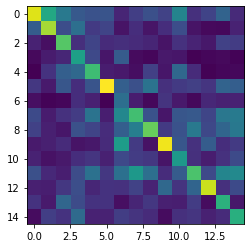

In [111]:
plt.imshow(con.PDC()[:,:,3:8].mean(axis=2))

In [91]:
arr=con.PDC()

In [93]:
arr[:,:,4:9]

array([[[0.93603608, 0.93600483, 0.93596611, 0.9359196 , 0.93586491],
        [0.59576919, 0.59507129, 0.59421006, 0.59318042, 0.59197624],
        [0.51968055, 0.51950376, 0.51928529, 0.51902368, 0.51871713],
        ...,
        [0.1218044 , 0.12180976, 0.1218164 , 0.12182436, 0.12183371],
        [0.35288896, 0.35282421, 0.3527442 , 0.35264836, 0.35253603],
        [0.10068047, 0.10067961, 0.10067856, 0.10067733, 0.10067594]],

       [[0.13720999, 0.13720639, 0.13720193, 0.13719658, 0.13719032],
        [0.35574523, 0.3583187 , 0.36146503, 0.36518506, 0.36948002],
        [0.06905568, 0.06903134, 0.06900128, 0.06896529, 0.06892315],
        ...,
        [0.01138613, 0.01141949, 0.01146068, 0.01150995, 0.0115676 ],
        [0.10947202, 0.10945782, 0.10944026, 0.10941922, 0.10939453],
        [0.02295188, 0.02298008, 0.02301493, 0.02305671, 0.0231057 ]],

       [[0.1320186 , 0.13206014, 0.13211158, 0.13217334, 0.13224591],
        [0.05188233, 0.0518264 , 0.05175739, 0.05167489, 0.0